In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
# load in the data
with open("pset2_data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
print(data.shape)

(13, 1024)


In [3]:
time = data[0]
sigmas = data[1]
signals = data[2:]

### Part 1
Find all 100-day sinusoidal period signals

In [4]:
# function to which we want to fit our data: one sinusoidal signal
def func_1sig(t, T, B, A1, A2):
    y = B + A1*np.cos(2*np.pi*t/T)+A2*np.sin(2*np.pi*t/T)
    return y

In [5]:
# linear least-squares fit
def lstsqfit(Y, A, C):
    # we want to solve Y = A @ X, weighted by the covariance
    a = A.T @ np.linalg.solve(C, A)
    b = A.T @ np.linalg.solve(C, Y)

    # a X = b
    theta = np.linalg.solve(a, b)
    cov = np.linalg.inv(a)

    return theta, cov

In [6]:
# linear least-squares fit to the single sinusoidal wave given by func_1sig()
def fit_1sig(data, T):
    # unpack the data
    t, y, sigmas = data['time'], data['signal'], data['sigmas']
    # construct the matrices
    Y = y
    A = np.column_stack((np.ones(len(t)), np.cos(2*np.pi*t/T), np.sin(2*np.pi*t/T)))
    C = np.diag(sigmas**2)

    # we want to solve Y = A @ X, weighted by the covariance
    theta, cov = lstsqfit(Y, A, C)

    return theta, cov

In [7]:
# compute chi-squared
def compute_chi_sq(y, mu, sigmas):
    res = y - mu
    chi_sq = np.sum(res**2 / sigmas**2)
    return chi_sq

Data set 0: A = 0.009, A_sigma = 0.020 ==> SNR = 0.45
Data set 1: A = 0.050, A_sigma = 0.020 ==> SNR = 2.53
Data set 2: A = 0.124, A_sigma = 0.020 ==> SNR = 6.22
Data set 3: A = 0.313, A_sigma = 0.020 ==> SNR = 15.76
Data set 4: A = 0.982, A_sigma = 0.020 ==> SNR = 49.44
Data set 5: A = 3.007, A_sigma = 0.020 ==> SNR = 151.44
Data set 6: A = 0.054, A_sigma = 0.020 ==> SNR = 2.71
Data set 7: A = 0.112, A_sigma = 0.020 ==> SNR = 5.65
Data set 8: A = 0.348, A_sigma = 0.020 ==> SNR = 17.54
Data set 9: A = 0.978, A_sigma = 0.020 ==> SNR = 49.26
Data set 10: A = 3.099, A_sigma = 0.020 ==> SNR = 156.06


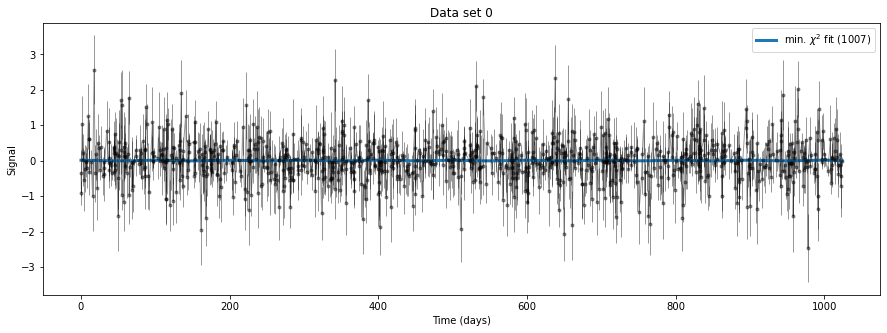

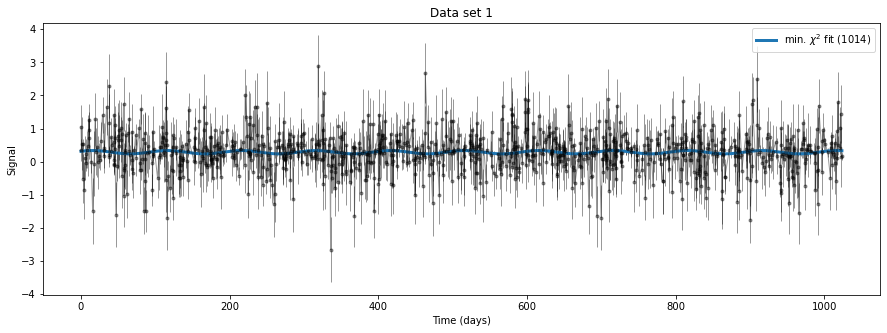

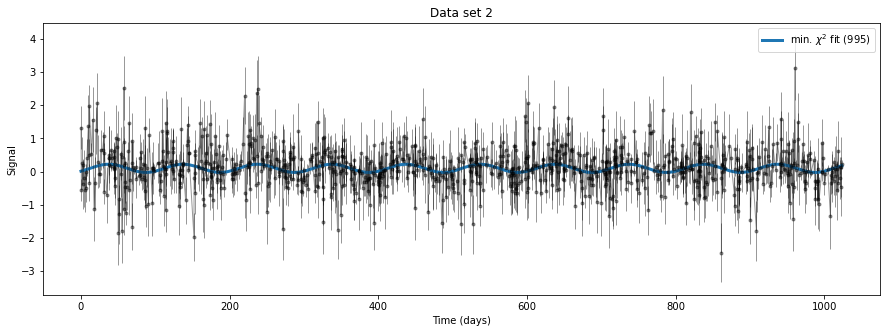

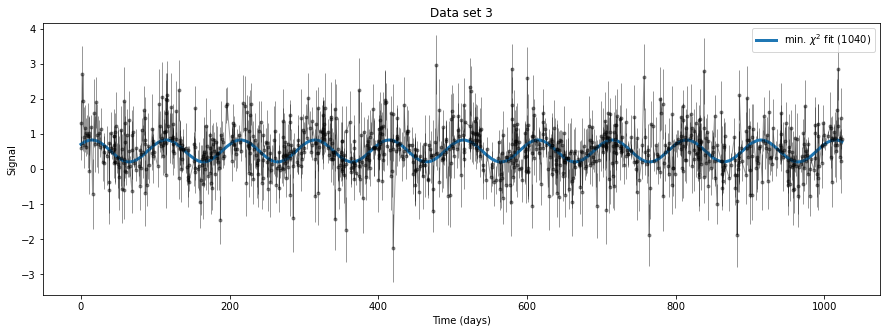

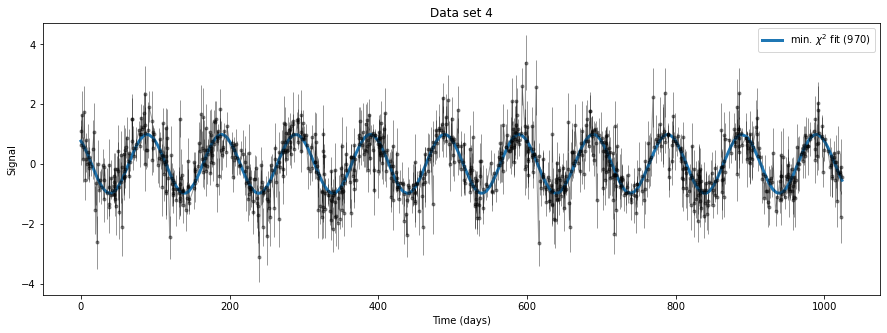

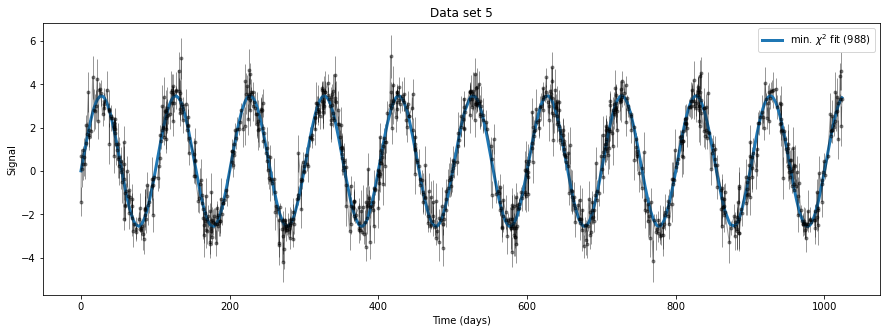

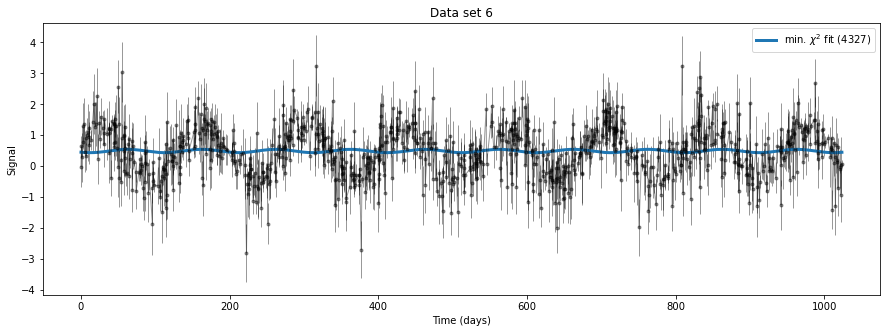

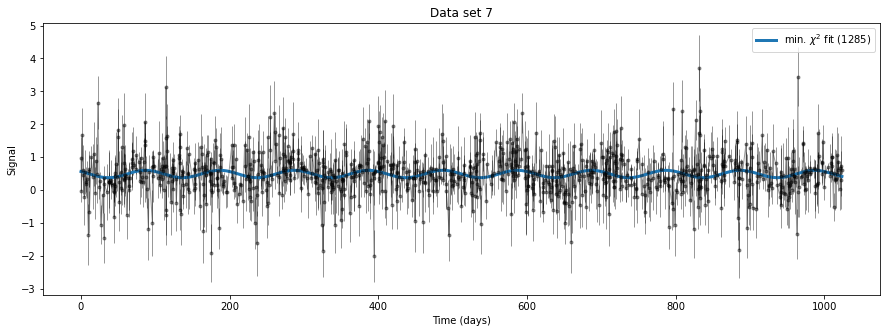

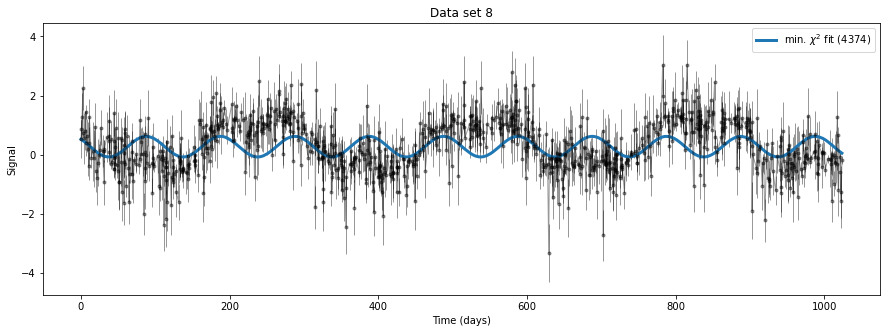

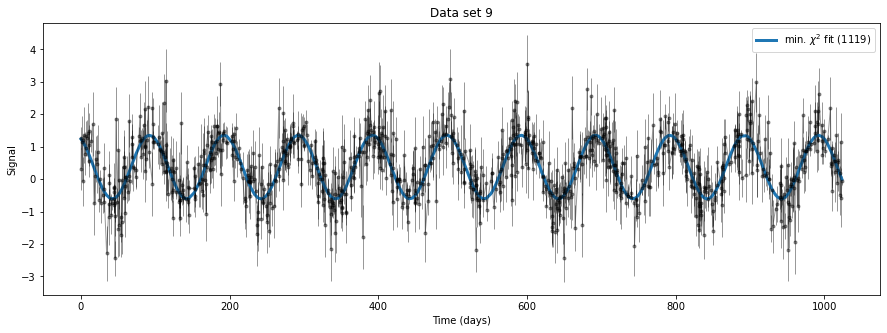

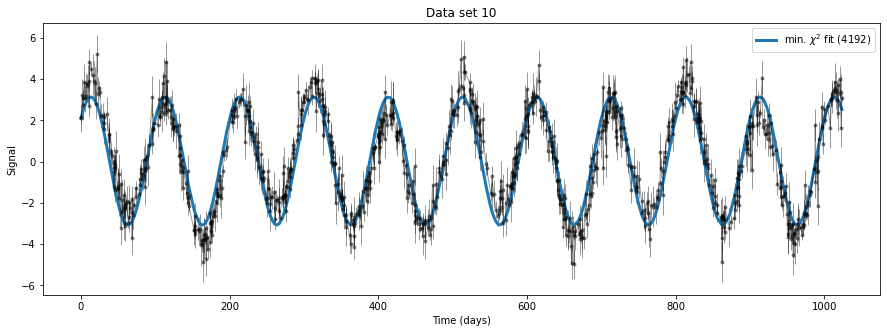

In [8]:
# loop through the eleven signals
data = {'time':time, 'sigmas':sigmas}  # we will define these outside of the loop since they are the same for all signals
T = 100

for i, signal in enumerate(signals):
    data['signal'] = signal

    # linear least-squares fit
    theta, cov = fit_1sig(data, T)
    B, A1, A2 = theta   # unpack best-fit params
    A = np.sqrt(A1**2 + A2**2)  # overall amplitude
    B_var, A1_var, A2_var = np.diag(cov)    # get variances
    A_sigma = np.sqrt(A1_var+A2_var)        # overall error
    snr = A/A_sigma                         # ~ signal-to-noise
    print(f"Data set {i}: A = {A:.3f}, A_sigma = {A_sigma:.3f} ==> SNR = {snr:.2f}")

    # plug best-fit params back into the signal equation to get the best fit
    fit = func_1sig(time, T, *theta)

    # compute chi-squared to assess goodness of fit
    chi_sq_val = compute_chi_sq(signal, fit, sigmas)

    # plot data and fitted 100-day signal
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.errorbar(time, data['signal'], yerr=sigmas, lw=1, color='k', marker='.', alpha=0.4)
    ax.plot(time, fit, lw=3, label=f'min. $\chi^2$ fit ({chi_sq_val:.0f})')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Signal')
    ax.set_title(f'Data set {i}')
    ax.legend()

I conclude that data sets 2-5 and 7-10 have sinusoidal signals with a period of 100 days with > 5 SNR.

### Part 2
Is there another signal?

In [9]:
# add an extra signal of unknown period
def func_2sigs(t, T, B, A1, A2, A3, A4, T0=100):
    y = B + A1*np.cos(2*np.pi*t/T0) + A2*np.sin(2*np.pi*t/T0) + A3*np.cos(2*np.pi*t/T) + A4*np.sin(2*np.pi*t/T)
    return y

In [10]:
# linear least-squares fit to the sinusoidal waveS given by func_2sig(), where the 100-day period is treated as a nuisance
def fit_2sigs(data, T, T0=100):
    # unpack the data
    t, y, sigmas = data['time'], data['signal'], data['sigmas']
    # construct the matrices
    Y = y
    A = np.column_stack((np.ones(len(t)), np.cos(2*np.pi*t/T0), np.sin(2*np.pi*t/T0), np.cos(2*np.pi*t/T), np.sin(2*np.pi*t/T)))
    C = np.diag(sigmas**2)

    # we want to solve Y = A @ X, weighted by the covariance
    theta, cov = lstsqfit(Y, A, C)

    return theta, cov

In [11]:
# for a single data set, compute chi-squared as a function of period (of the second signal; remember the 100-day signal is treated as a nuisance)
def get_chi_sqs(data, periods, T0=100):
    n = len(periods)
    time, signal, sigmas = data['time'], data['signal'], data['sigmas']
    chi_squareds = np.zeros(n)

    for i, T in enumerate(periods):
        theta, cov = fit_2sigs(data, T, T0=T0)
        fit = func_2sigs(time, T, *theta, T0=T0)
        chi_squareds[i] = compute_chi_sq(signal, fit, sigmas)
    
    return chi_squareds

In [12]:
# loop through a range of "reasonable" periods given the data, and see which one minimizes chi-squared in our least-squares fit
n = 100
periods = np.logspace(1, 3, n)

In [13]:
# data to use (we will add the actual signal in the for loop)
data = {'time':time, 'sigmas':sigmas}
# the signals that we have concluded do have an 100-day period signal
signals_T100 = np.row_stack((signals[2:6], signals[7:]))
set_nums = [2,3,4,5,7,8,9,10]   # and the set numbers to go along (for labelling)

In [14]:
chi_squareds = np.empty((len(signals_T100), n))
for i, signal in enumerate(signals_T100):
    data['signal'] = signal

    # get chi-squareds
    chi_squareds[i] = get_chi_sqs(data, periods)

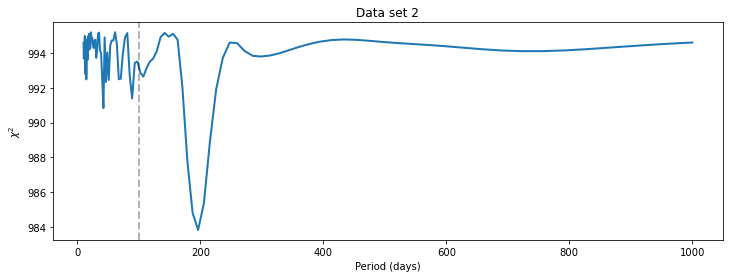

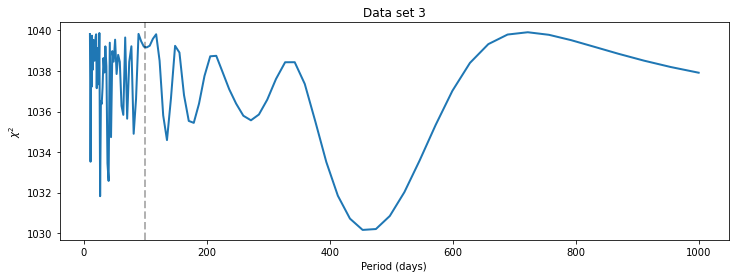

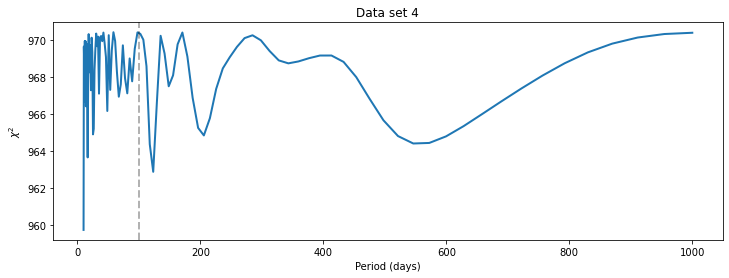

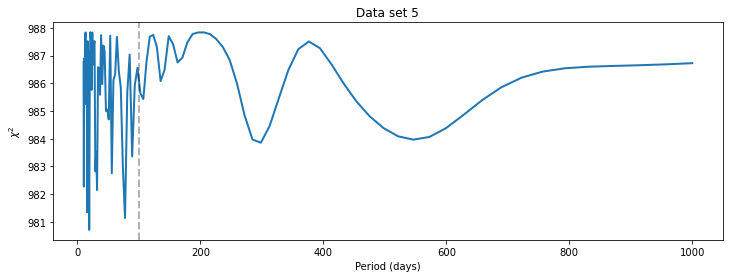

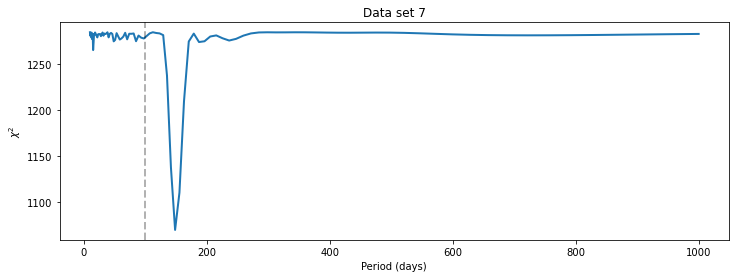

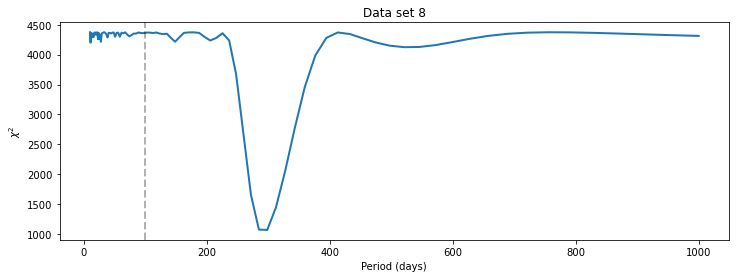

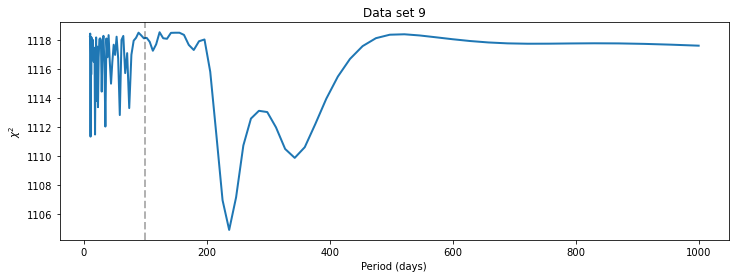

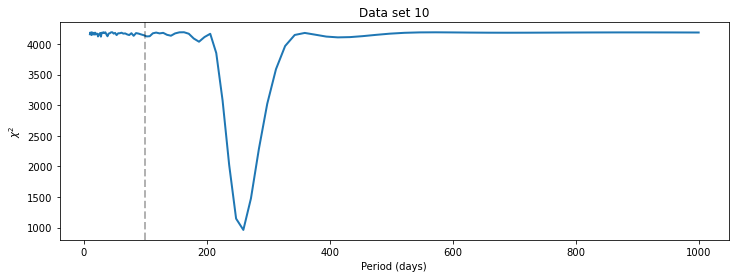

In [15]:
for i in range(len(signals_T100)):
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(periods, chi_squareds[i], lw=2)
    ax.axvline(100, lw=2, color='k', alpha=0.3, ls='--')
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('$\chi^2$')
    ax.set_title(f'Data set {set_nums[i]}')

This is not a very rigorous procedure, but I will for the sake of time just take any dip in $\chi^2$ with a height of > ~20 to be a second signal.
Then we have

In [16]:
for i, chi_sq in enumerate(chi_squareds):
    idx = np.where(chi_sq==min(chi_sq))
    period = int(periods[idx])
    print(f"Data set {set_nums[i]}: min chi-squared = {min(chi_sq):.0f} at T = {period} days")

Data set 2: min chi-squared = 984 at T = 196 days
Data set 3: min chi-squared = 1030 at T = 453 days
Data set 4: min chi-squared = 960 at T = 10 days
Data set 5: min chi-squared = 981 at T = 19 days
Data set 7: min chi-squared = 1070 at T = 148 days
Data set 8: min chi-squared = 1071 at T = 298 days
Data set 9: min chi-squared = 1105 at T = 236 days
Data set 10: min chi-squared = 962 at T = 259 days


Based on these results, I will conclude that Data sets 7, 8, and 10 each have an additional sinusoidal signal with periods of 148, 298, and 259 days, respectively.

### Part 3
Repeat Part 1, treating newly-found additional signals as nuisances.

In [17]:
# so we will only focus on Data sets 7, 8, and 10

In [18]:
signals_2sigs = np.row_stack((signals[7:9], signals[10]))
set_nums = [7,8,10]

In [19]:
second_Ts = [148, 298, 259]

In [20]:
# loop through a range of "reasonable" periods given the data, and see which one minimizes chi-squared in our least-squares fit
n = 100
periods = np.logspace(1, 3, n)

In [22]:
chi_squareds = np.empty((len(signals_2sigs), n))
for i, signal in enumerate(signals_2sigs):
    data['signal'] = signal
    print(f"searching data set {set_nums[i]} for another signal besides T = {second_Ts[i]} days...")

    # get chi-squareds
    chi_squareds[i] = get_chi_sqs(data, periods, T0=second_Ts[i])

searching data set 7 for another signal besides T = 148 days...
searching data set 8 for another signal besides T = 298 days...
searching data set 10 for another signal besides T = 259 days...


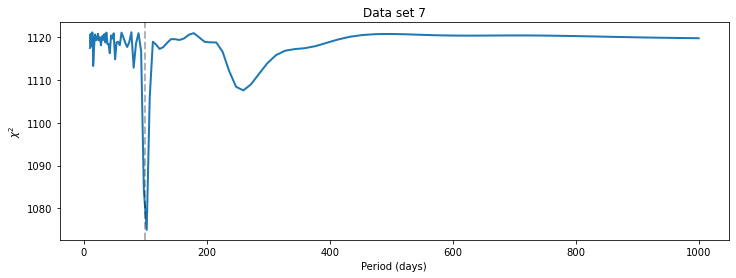

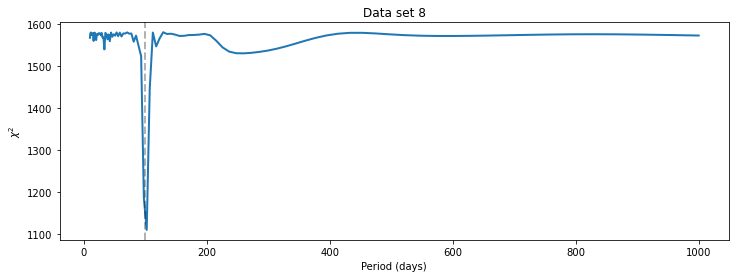

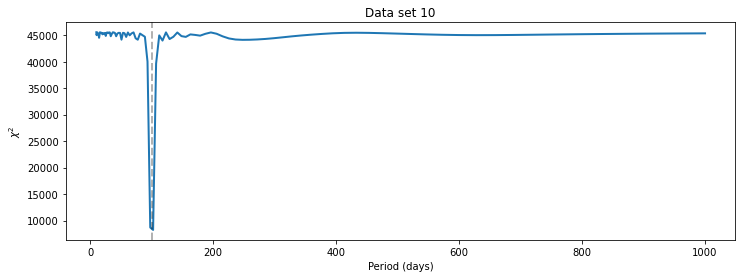

In [23]:
for i in range(len(signals_2sigs)):
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(periods, chi_squareds[i], lw=2)
    ax.axvline(100, lw=2, color='k', alpha=0.3, ls='--')
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('$\chi^2$')
    ax.set_title(f'Data set {set_nums[i]}')